In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')



ibmqfactory.load_account:WARNING:2024-01-29 15:25:26,716: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm

ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2) * 2 * np.pi))


def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2 * x * np.pi) / (2 * x * np.pi) if x != 0 else 1))
    return X


def fisher_inf(x, w, a):
    cos_wx_squared = np.cos(w * x) ** 2
    sin_wx_squared = np.sin(w * x) ** 2
    exp_ax = np.exp(a * x)

    term1 = x ** 2 * cos_wx_squared / (exp_ax + np.cos(w * x)) ** 2
    term2 = x ** 2 * sin_wx_squared / (exp_ax + np.cos(w * x)) ** 2

    return term1 + term2


def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

In [64]:
import numpy as np
import math

n = 1
T = np.pi
shots = 100
measurements = 50
delay = np.linspace(0, T, measurements)

W = [random.gauss(3, 1) for _ in range(n)]
L = [random.gauss(1, 1) for _ in range(n)]
J = [random.gauss(3, 1) for _ in range(n - 1)]

L = [3.2]

W = [3]
J = [0, 1]

total_shots = shots * measurements
fisher_values = [fisher_inf(t, W[0], L[0]) for t in delay]
Shots = [math.ceil(total_shots * fisher_values[i] / sum(fisher_values)) for i in range(measurements)]
Shots = [Shots[i] if Shots[i] > 0 else 1 for i in range(measurements)]

print("J = ", J)
print("W = ", W)

batch1 = []
batch2 = []

exp = []
W_estimate = 10
L_estimate = 1
time_measured = []
for i in tqdm(range(measurements), desc="Creating experiments"):
    current_fisher = fisher_inf(delay, W_estimate, L_estimate)
    best_t = np.argmax(current_fisher)
    exp.append(RamseyExperiment(n, delay[best_t], 100, J, W, L))
    exp.append(RamseyExperiment(n, delay[i], Shots[i], J, W, L))
    exp[i].create_circuit_detuning()
    exp[i].add_decay_raw()
    batch1.append(exp[i])
    W_estimate = RamseyBatch(batch1).fit_to_theory()[0][1]
    L_estimate = RamseyBatch(batch1).fit_to_theory()[0][0]
    time_measured.append(delay[best_t])
print("W_estimate = ", W_estimate)
print("L_estimate = ", L_estimate)

print("time_measured = ", time_measured)

J =  [0, 1]
W =  [3]


Creating experiments: 100%|██████████| 50/50 [00:00<00:00, 135.24it/s]

W_estimate =  2.742538688413996
L_estimate =  3.0704848695292957
time_measured =  [2.0516523452014974, 0.0641141357875468, 2.6286795672894185, 2.5645654315018716, 2.6286795672894185, 2.821021974652059, 2.500451295714325, 2.500451295714325, 1.0258261726007487, 1.7310816662637634, 1.4105109873260295, 1.4105109873260295, 1.3463968515384828, 1.3463968515384828, 1.218168579963389, 1.218168579963389, 1.2822827157509358, 1.218168579963389, 1.0899403083882955, 0.7693696294505615, 0.7052554936630148, 0.7052554936630148, 0.7052554936630148, 0.7052554936630148, 0.7052554936630148, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6411413578754679, 0.6

In [3]:
import numpy as np
from scipy.optimize import minimize


# Define the function
def vw(t, a, w):
    t1, t2 = t
    term1 = np.exp(2 * a * t1) * t2 ** 2 * np.cos(t2 * w) ** 2
    term2 = 2 * np.exp(a * t1) * t2 ** 2 * np.cos(t1 * w) * np.cos(t2 * w) ** 2
    term3 = np.cos(t1 * w) ** 2 * (np.exp(2 * a * t2) * t1 ** 2 + 2 * np.exp(a * t2) * t1 ** 2 * np.cos(t2 * w) + (
            t1 ** 2 + t2 ** 2) * np.cos(t2 * w) ** 2)
    term4 = (1 / np.sin((t1 - t2) * w)) ** 2
    return (term1 + term2 + term3) * term4 / (t1 ** 2 * t2 ** 2)


# Constants
a = 1.4
w = 3

# Constraints
cons = ({'type': 'ineq', 'fun': lambda t: t[0] - t[1]},  # t1 > t2
        {'type': 'ineq', 'fun': lambda t: t[0]},  # t1 > 0
        {'type': 'ineq', 'fun': lambda t: t[1] - 1})  # t2 > 1

# Initial guess
initial_guess = [3, 3]

# Optimization
result = minimize(vw, initial_guess, args=(a, w), constraints=cons, method='SLSQP')

if result.success:
    optimized_t1, optimized_t2 = result.x
    print("Minimum at t1 =", optimized_t1, "t2 =", optimized_t2)
    print("Minimum value of vw:", result.fun)
else:
    print("Optimization failed:", result.message)


Optimization failed: Inequality constraints incompatible


C:\Users\user\AppData\Local\Temp\ipykernel_20644\1986094366.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  term4 = (1 / np.sin((t1 - t2) * w)) ** 2


In [6]:
import numpy as np


def p(t, w, a):
    return 1 / 2 * (1 + np.cos(w * t) * np.exp(-a * t))


def pw(t, w, a):
    return - 1 / 2 * t * np.sin(w * t) * np.exp(-a * t)


def pww(t, w, a):
    return - 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def pa(t, w, a):
    return - 1 / 2 * t * np.cos(w * t) * np.exp(-a * t)


def paa(t, w, a):
    return 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def paw(t, w, a):
    return 1 / 2 * t ** 2 * np.sin(w * t) * np.exp(-a * t)


def fisher_matrix(t, w, a, shots):
    Iww = 0
    Iaa = 0
    Iwa = 0

    for i in range(len(t)):
        p0 = p(t[i], w, a)
        p1 = 1 - p0
        pw0 = pw(t[i], w, a)
        pw1 = -pw0
        pww0 = pww(t[i], w, a)
        pww1 = -pww0
        pa0 = pa(t[i], w, a)
        pa1 = -pa0
        paa0 = paa(t[i], w, a)
        paa1 = -paa0
        paw0 = paw(t[i], w, a)
        paw1 = -paw0

        if p0 == 0:
            p0 = 1e-10
        if p1 == 0:
            p1 = 1e-10

        # Iww -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
        #                                                                     ** 2) / p1 ** 2))
        # Iaa -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
        # Iwa -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        Iww += shots[i] * (p0 * ((pw0 ** 2) / p0 ** 2) + p1 * ((pw1 ** 2) / p1 ** 2))
        Iaa += shots[i] * (p0 * ((pa0 ** 2) / p0 ** 2) + p1 * ((pa1 ** 2) / p1 ** 2))
        Iwa += shots[i] * (p0 * ((pw0 * pa0) / p0 ** 2) + p1 * ((pw1 * pa1) / p1 ** 2))
    return np.array([[Iww, Iwa], [Iwa, Iaa]])



def lower_bound(f_mat):
    inv = np.linalg.inv(f_mat)
    w_var = np.sqrt(inv[0, 0])
    a_var = np.sqrt(inv[1, 1])

    #a_var = np.sqrt(inv[1, 1])
    return w_var, a_var



In [86]:
import pandas as pd

excel_path = 'results/w_df_2.xlsx'
df = pd.read_excel(excel_path)
w_dist_reshaped = df['w_dist_reshaped'].tolist()
w_error = df['w_error'].tolist()
w_std = df['w_std'].tolist()

excel_path = 'results/decay_df_2.xlsx'
df = pd.read_excel(excel_path)
decay_dist_reshaped = df['decay_dist_reshaped'].tolist()
decay_error = df['decay_error'].tolist()
decay_std = df['decay_std'].tolist()

excel_path = 'results/j_df_2.xlsx'
df = pd.read_excel(excel_path)
j_dist_reshaped = df['j_dist_reshaped'].tolist()
j_error = df['j_error'].tolist()
j_std = df['j_std'].tolist()


NameError: name 'w_error' is not defined

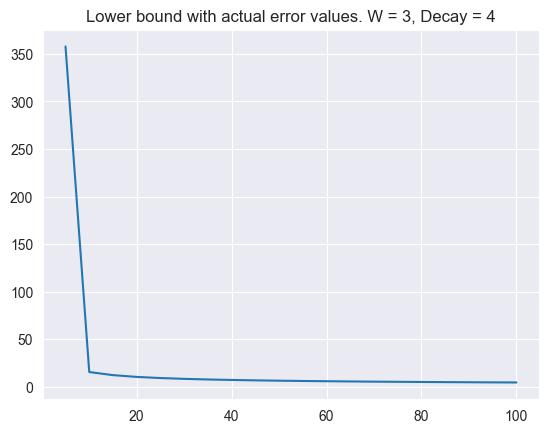

In [7]:
T = np.pi
shots = 1000
measurements = np.arange(5, 105, 5)
w = 3
decay = 4
w_bounds = []
a_bounds = []
for m in measurements:
    delay = np.linspace(0, T, m)
    Shots = len(delay) * [shots]
    fisher = fisher_matrix(delay, w, decay, Shots)
    w_bound, a_bound = lower_bound(fisher)
    w_bounds.append(100 * w_bound / w)
    a_bounds.append(100 * a_bound / decay)

plt.title(f'Lower bound with actual error values. W = {w}, Decay = {decay}')
from matplotlib import ticker

#plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.plot(measurements, w_bounds, label="w lower bound")
plt.errorbar(measurements, w_error, yerr=w_std, fmt='o', label='W')
# plt.plot(measurements, a_bounds, label="a lower bound", color="orange")
# plt.errorbar(measurements, decay_error, yerr=decay_std, fmt='o', label='Decay')
#plt.errorbar(measurements, j_error, yerr=j_std, fmt='o', label='J')
#plt.semilogy()
plt.ylim([0, 30])
plt.grid()
plt.legend()

In [12]:
from scipy.optimize import minimize


def find_optimal_times(w, a, N, Total_Shots=1000):
    def model_func(params):
        t = params[0:N]
        shots = params[N:2 * N]
        Iww = 0
        Iaa = 0
        Iwa = 0

        for i in range(len(t)):
            p0 = p(t[i], w, a)
            p1 = 1 - p0
            pw0 = pw(t[i], w, a)
            pw1 = -pw0
            pww0 = pww(t[i], w, a)
            pww1 = -pww0
            pa0 = pa(t[i], w, a)
            pa1 = -pa0
            paa0 = paa(t[i], w, a)
            paa1 = -paa0
            paw0 = paw(t[i], w, a)
            paw1 = -paw0

            if p0 == 0:
                p0 = 1e-10
            if p1 == 0:
                p1 = 1e-10

            Iww -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
                                                                                ** 2) / p1 ** 2))
            Iaa -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
            Iwa -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        lower_w_bound = 10000 * Iaa / (Iaa * Iww - Iwa ** 2)
        lower_a_bound = 10000 * Iww / (Iaa * Iww - Iwa ** 2)
        return lower_w_bound + lower_a_bound

    def shots_constraint(params):
        return np.sum(params[N:2 * N]) - Total_Shots

    # Define the constraint as a dictionary
    cons = ({'type': 'eq', 'fun': shots_constraint})
    initial_guess = np.concatenate([np.random.uniform(0, np.pi, N), np.full(N, Total_Shots / N)])
    result = minimize(model_func, initial_guess, method='trust-constr', bounds=[(0, np.pi)] * N + [(0, 1000)] * N,
                      constraints=cons)
    return result.x


def process_result(result):
    times = result[0:N]
    shots = result[N:2 * N]

    grouped_times = []
    grouped_shots = []

    for i in range(len(times)):
        for j in range(len(grouped_times)):
            if abs(grouped_times[j] - times[i]) < 0.005:
                #grouped_times.append(times[i])
                grouped_shots[j] += shots[i]
                break
        else:
            grouped_times.append(times[i])
            grouped_shots.append(shots[i])

    paired = sorted(zip(grouped_times, grouped_shots))
    times = [x for x, _ in paired]
    shots = [int(round(y)) for _, y in paired]

    return times, shots


N = 10
Total_Shots = N * 100
w = 10
a = 5
result = find_optimal_times(w, a, N, Total_Shots)
optimal_times, optimal_shots = process_result(result)

regular_times = np.linspace(0, np.pi, N)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)


Optimal times =  [0.14068959094838432, 0.2893931112085669, 1.5963110783177519, 2.026752603900133]
Optimal shots =  [500, 500, 0, 0]


In [263]:


optimal_times, optimal_shots = process_result(result)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
print(sum(optimal_shots))
optimal_w_bound = np.sum(lower_bound(fisher_matrix(optimal_times, w, a, optimal_shots)))
regular_w_bound = np.sum(lower_bound(fisher_matrix(regular_times, w, a, N * [100])))
print("Optimal w bound = ", optimal_w_bound)
print("Regular w bound = ", regular_w_bound)

Optimal times =  [0.1479802787597646, 0.594898480300336]
Optimal shots =  [92, 108]
200
Optimal w bound =  1.908139647502782
Regular w bound =  6.014973060916628e+25


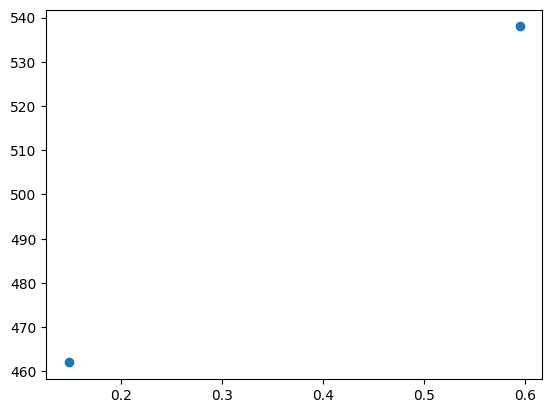

In [265]:

plt.scatter(optimal_times, optimal_shots, label="Optimal")


In [233]:
import sympy as sp

# Define the variables
w, a, x, t1, t2 = sp.symbols('w a x t1 t2')
times = [t1, t2]


# Define the functions p[1, t, w, a] and p[-1, t, w, a]
def p(x, t, w, a):
    return 1 / 2 * (1 + x * sp.cos(w * t) * sp.exp(-a * t))


# Define the function f(t, w, a, x)
def f(t, w, a, x):
    return p(x, t, w, a) ** ((x + 1) / 2) * (1 - p(x, t, w, a)) ** ((1 - x) / 2)


# Calculate partial derivatives of the log-likelihood function
def partialW(t, w, a, x):
    return sp.diff(p(x, t, w, a), w)


def partialA(t, w, a, x):
    return sp.diff(p(x, t, w, a), a)


def partialWW(t, w, a, x):
    return sp.diff(partialW(t, w, a, x), w)


def partialAA(t, w, a, x):
    return sp.diff(partialA(t, w, a, x), a)


def partialAW(t, w, a, x):
    return sp.diff(partialA(t, w, a, x), w)


# Define the information matrix components
def i_wa(times, w, a):
    val = 0
    for t in times:
        val += sum([(partialW(t, w, a, xi) * partialA(t, w, a, xi)) / p(xi, t, w, a) for xi in [-1, 1]])
    return val


def i_ww(times, w, a):
    val = 0
    for t in times:
        val += sum([(partialW(t, w, a, xi) ** 2) / p(xi, t, w, a) for xi in [-1, 1]])
    return val


def i_aa(times, w, a):
    val = 0
    for t in times:
        val += sum([(partialA(t, w, a, xi) ** 2) / p(xi, t, w, a) for xi in [-1, 1]])
    return val


# Define VarA
VarA = i_ww(times, w, a) / (i_ww(times, w, a) * i_aa(times, w, a) - 2 * i_wa(times, w, a))
VarW = i_aa(times, w, a) / (i_ww(times, w, a) * i_aa(times, w, a) - 2 * i_wa(times, w, a))

Var = VarA + VarW

# Substitute w = a = 3
VarA_sub = VarA.subs({w: 3, a: 3})

# Find the minimum values of t1 and t2
min_t1_t2 = sp.solve([sp.diff(VarA_sub, t1), sp.diff(VarA_sub, t2)], (t1, t2))
min_t1_t2


KeyboardInterrupt: 

In [232]:
VarA

1.0*(exp(a*t1) - cos(t1*w))*(exp(a*t1) + cos(t1*w))*(exp(a*t2) - cos(t2*w))*(exp(a*t2) + cos(t2*w))*(-t1**2*exp(2*a*t2)*sin(t1*w)**2 - t1**2*sin(t1*w)**2*sin(t2*w)**2 + t1**2*sin(t1*w)**2 - t2**2*exp(2*a*t1)*sin(t2*w)**2 - t2**2*sin(t1*w)**2*sin(t2*w)**2 + t2**2*sin(t2*w)**2)*exp(-a*t1 - a*t2 + 2*a*(t1 + t2))/(t1**2*(exp(a*t1) - cos(t1*w))**2*(exp(a*t1) + cos(t1*w))*(exp(a*t2) - cos(t2*w))**2*(exp(a*t2) + cos(t2*w))**2*exp(a*t2)*sin(t1*w)*cos(t1*w) + t1**2*(exp(a*t1) - cos(t1*w))*(exp(a*t1) + cos(t1*w))**2*(exp(a*t2) - cos(t2*w))**2*(exp(a*t2) + cos(t2*w))**2*exp(a*t2)*sin(t1*w)*cos(t1*w) + t2**2*(exp(a*t1) - cos(t1*w))**2*(exp(a*t1) + cos(t1*w))**2*(exp(a*t2) - cos(t2*w))**2*(exp(a*t2) + cos(t2*w))*exp(a*t1)*sin(t2*w)*cos(t2*w) + t2**2*(exp(a*t1) - cos(t1*w))**2*(exp(a*t1) + cos(t1*w))**2*(exp(a*t2) - cos(t2*w))*(exp(a*t2) + cos(t2*w))**2*exp(a*t1)*sin(t2*w)*cos(t2*w) - (t1**2*exp(2*a*t2)*cos(t1*w)**2 - t1**2*cos(t1*w)**2*cos(t2*w)**2 + t2**2*exp(2*a*t1)*cos(t2*w)**2 - t2**2*cos(t1*w)